# AMPLYFI Article Analysis
## Using the OSEMN Process to conduct Exploratory Data Analysis

### OSEMN stands for Obtain, Scrub, Explore, Model, and iNterpret. All stages of the process are used for Machine Learning projects. 

### This is an Exploratory Data Analysis project and uses only the Obtain, Scrub, Explore steps to discover insights about the Environmental, Societal, and Governance (ESG) Article dataset.

More details on OSEMN found here: https://machinelearningmastery.com/how-to-work-through-a-problem-like-a-data-scientist/ 

In [1]:
import mongoActions
import nlpActions
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## Obtain the data
### Original data was a ~10,000 json files containing articles. The following steps were taken to obtain the data used in this analysis:
- Articles were ingested into a MongoDB by a process that also obtained metatdata for each article (wordCount, lists of Entities, entityMentions, standardized source name). See populateMongo.py and nlpActions.py for this code.
- Articles to be analysed are retrieved from the document store (MongoDB)

In [2]:
all_arts_df = pd.DataFrame(mongoActions.get_articles_no_text())

In [3]:
# Functions and global variables
entity_labels = ["person", "norp", "fac", "org", "gpe", "loc", "product", "event", "law"]

def calc_most_common(entity_values, most_common_n):
    # getting the counts for entity values
    entity_dict = {}
    for e_list in entity_values:
        for e in e_list:
            if e in entity_dict:
                entity_dict[e] = entity_dict[e] + 1
            else:
                entity_dict[e] = 1
    most_common_entities = dict(Counter(entity_dict).most_common(most_common_n))
    return most_common_entities

def get_source_most_common_entities(source, entity_label, top_n):
    most_common = None
    src_df = all_arts_df[all_arts_df["sourceStandardized"] == source]
    src_ents = src_df[entity_label]
    if not src_ents.empty:
        src_ents_values = src_ents.values
        most_common = calc_most_common(src_ents_values, top_n)
    return most_common

def get_year_most_common_entities(pubYear, entity_label, top_n):
    year_most_common = None
    year_df = all_arts_df[all_arts_df["publishYear"] == pubYear]
    year_ents = year_df[entity_label]
    if not year_ents.empty:
        year_ents_values = year_ents.values
        year_most_common = calc_most_common(year_ents_values, top_n)
    return year_most_common

def plot_most_common_entities(top_entities, cols, facet_name, color, figsize=(6,8)):
        plt_df = pd.DataFrame(list(top_entities.items()), columns=cols)
        entity_label = cols[0]
        fig = plt_df.plot.barh(legend=False, color=color, figsize=figsize)
        plt.title(f"Top {plt_df.shape[0]} {entity_label} in {facet_name}")
        plt.ylabel(entity_label)
        plt.yticks(range(plt_df.shape[0]), plt_df[entity_label].values)
        plt.xlabel(f"Total Articles Mentioning Entity")
        plt.show.legend=False
        plt.show()

# set the plot theme to seaborn
sns.set_theme()
# set the face color globally for all axes objects
plt.rcParams.update({'axes.facecolor':'whitesmoke'})


## Scrub
### Even though some preprocesing was done, some data cleaning/scrubbing is needed
- Drop Duplicates
- Confirm data types are as expected
- No need for null checks as the data ingestion to MongoDB addressed this.

In [4]:
# Some duplicate articles were added by mistake at ingest into MongoDB. Remove them.
all_arts_df.drop_duplicates(subset=["id"], inplace=True)

In [5]:
# Inspect the dataframe
all_arts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9993 entries, 0 to 10492
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  9993 non-null   object
 1   source              9993 non-null   object
 2   publishDate         9993 non-null   object
 3   sourceStandardized  9993 non-null   object
 4   wordCount           9993 non-null   int64 
 5   publishYear         9993 non-null   int64 
 6   publishMonth        9993 non-null   int64 
 7   entityMentions      9993 non-null   int64 
 8   person              9993 non-null   object
 9   norp                9993 non-null   object
 10  fac                 9993 non-null   object
 11  org                 9993 non-null   object
 12  gpe                 9993 non-null   object
 13  loc                 9993 non-null   object
 14  product             9993 non-null   object
 15  event               9993 non-null   object
 16  law                 999

In [6]:
# Objects types for every attribute except for publishDate are acceptable.  
# Change publishDate to datetime in case we'd like to use this in exploration
all_arts_df["publishDate"] = pd.to_datetime(all_arts_df["publishDate"])

## Explore
### Get some basic information about the entire article dataset
- Total Articles
- Total Sources
- Word Count Stats
- Entity Mention Stats
- Publish Date Range

In [7]:
# Get basic stats for all articles
article_count = all_arts_df.shape[0]
source_count = len(all_arts_df["sourceStandardized"].unique())
min_pubdate = all_arts_df["publishDate"].min()
max_pubdate = all_arts_df["publishDate"].max()
min_wc = all_arts_df["wordCount"].min()
max_wc = all_arts_df["wordCount"].max()
avg_wc = round(all_arts_df["wordCount"].mean())
med_wc = round(all_arts_df["wordCount"].median())
min_em = all_arts_df["entityMentions"].min()
max_em = all_arts_df["entityMentions"].max()
avg_em = round(all_arts_df["entityMentions"].mean())
med_em = round(all_arts_df["entityMentions"].median())
print(f"Basic Stats: {article_count} Total Articles, {source_count} Total Sources\n")
print(f"Word Count Stats: {min_wc} Min, {max_wc} Max, {avg_wc} Avg, {med_wc} Median\n")
print(f"Entity Mention Stats: {min_em} Min, {max_em} Max, {avg_em} Avg, {med_em} Median\n")
print(f"Publication date range is {min_pubdate} through {max_pubdate}\n")


Basic Stats: 9993 Total Articles, 1245 Total Sources

Word Count Stats: 37 Min, 23187 Max, 1244 Avg, 682 Median

Entity Mention Stats: 0 Min, 1269 Max, 61 Avg, 35 Median

Publication date range is 2014-12-04 07:06:00+00:00 through 2020-12-30 20:41:28+00:00



## Explore
#### What are the article counts for each Year in the Publish Date range?


Text(0, 0.5, 'Count')

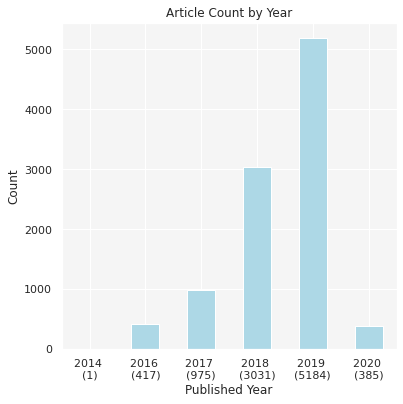

In [8]:


all_arts_year_gb = all_arts_df.groupby("publishYear")["id"].count() 

xticklabels = []
i = 0
for i in range(len(all_arts_year_gb.values)):
    ticklabel = str(all_arts_year_gb.index[i]) + " \n(" + str(all_arts_year_gb.values[i]) + ")"
    xticklabels.append(ticklabel)
    i+=1

ax = all_arts_year_gb.plot(kind="bar", rot=0, figsize=(6,6), color="lightblue")
ax.set_xticklabels(xticklabels)

plt.title("Article Count by Year")
plt.xlabel("Published Year")
plt.ylabel("Count")


## Explore

### Now that we've discovered some basic information, let's pose 1-2 Analysis Questions and explore the data for insights into these specific areas.


## Exploration Point: The Year with the most Articles
### 2019 had the most articles (5184 in total).

### What might be interesting about these ESG articles. Exploring PERSON and EVENT entities mentioned in these articles might provide context/insight.


## Insights
### Politicians\World Leaders dominated PERSON entity mentions in the 2019 Articles in the dataset.
- This is not surprising since the articles were taken from AMPLYFI's harvest engine in relation to Environmental, Societal and Governance (ESG) terms.

### The EVENT entity mentions also appear to be in alignment with an ESG search
- Sporting Events: Olympic Games, World Cup, U.S. Open, Super Bowl
- Annual Events: Cyber Monday, Black Friday, New Year, Chinese New Year, Holy Week, Independence Day
- Historic events: the Financial Crisis, the Civil War, Great Depression, the Korean War, Industrial Revolution, the Vietnam War, the Iraq War, Word War I, Watergate, Holocaust, the Cold War, World War II
- Climate and Science Events: Hurricanes Irma and Dorian and Maria and Hugo, the Paris Climate Accord, Horizon 2020, United Nations Climate Action Summit 

### Why is WW II mentioned so often in 2019?
- A short Google research session reveals that the 75th Anniversary of D-Day occured in June and the 80th Anniversary of the start of WW II was in September.


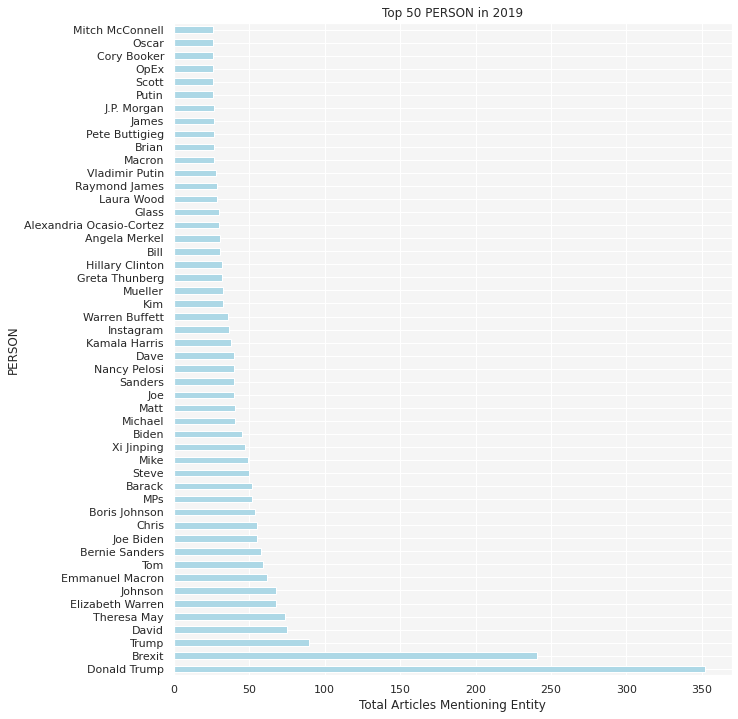

In [9]:
# What PEERSON entities were detected in the 2019 ESG articles?
year_common_ents_per = get_year_most_common_entities(2019, "person", 50)
plot_most_common_entities(year_common_ents_per, ["PERSON", "Article Count"], "2019", "lightblue", (10,12))
# Politicians\World Leaders made up the  majority of Person entity mentions in 2019

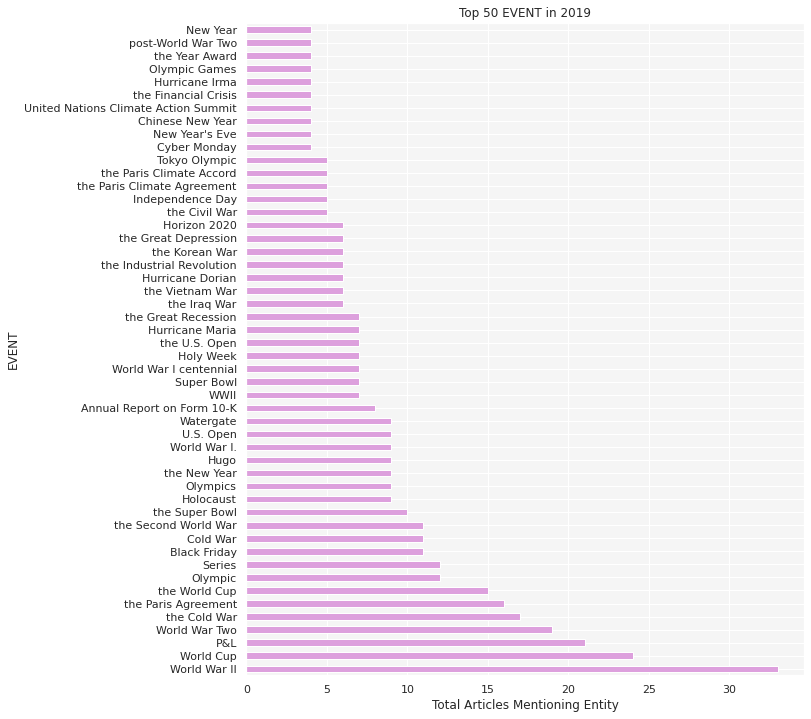

In [10]:
# What EVENT entities were detected in the 2019 ESG articles?
year_common_ents_per = get_year_most_common_entities(2019, "event", 50)
plot_most_common_entities(year_common_ents_per, ["EVENT", "Article Count"], "2019", "plum", (10,12))


# These Events do appear relevant to an ESG search 
#
# Sporting events: Olympic Games, World Cup, U.S. Open, Super Bowl
#
# Annual Events: Cyber Monday, Black Friday, New Year, Chinese New Year, Holy Week, Independence Day

# Historic events: he Financial Crisis, the Civil War, Great Depression, the Korean War, Industrial Revolution, 
# the Vietnam War, the Iraq War, Word War I, Watergate, Holocaust, the Cold War, World War II
# 
# Climate and Science Events: Hurricanes Irma and Dorian and Maria and Hugo, the Paris Climate Accord, 
# Horizon 2020, United Nations Climate Action Summit 
#
# Why is WW II mentioned so often in 2019?
# Quick Google research shows that the 75th Anniversary of D-Day occured in June and the
# 80th Anniversary of the start of WW II was in September.

## General Insights
### The current Entity Extraction tool (SpaCy) could be improved or replaced with a better version.
- Instagram and Brexit should not be considered Person entities

### An Entity Resolution tool would be helpful for future analysis.
- If analysis are searching for Entities using "keyword" searches, they should be aware of the different ways Entities can be mentioned. 
- For example: multiple PERSON representations for Joe Biden exist (Biden, Joe, and Joe Biden) so being aware of variations could help analysts create a better keyword search term list.


## Exploration Point 2:  Sources
### How might we analyse and compare all the Sources? Comparing by article count per source seems to be a good place to start.

In [11]:
# Group all articles by source
allsources_gb = all_arts_df.groupby("sourceStandardized")
allsources_art_counts = allsources_gb["id"].count()

### Get Min/Max/Average/Median Article Counts by Source

In [12]:
sources_min_art_count = allsources_art_counts.min()
sources_max_art_count = allsources_art_counts.max()
sources_avg_art_count  = round(allsources_art_counts.mean())
sources_median_art_count = round(allsources_art_counts.median())
print("Source article count stats: \n")
print(f"Min article count: {sources_min_art_count} \n")
print(f"Max article count: {sources_max_art_count} \n")
print(f"Average article count:{sources_avg_art_count} Avg\n")
print(f"Median article count: {sources_median_art_count}\n")


Source article count stats: 

Min article count: 1 

Max article count: 1790 

Average article count:8 Avg

Median article count: 1



### Source article counts are right skewed with strong outliers.

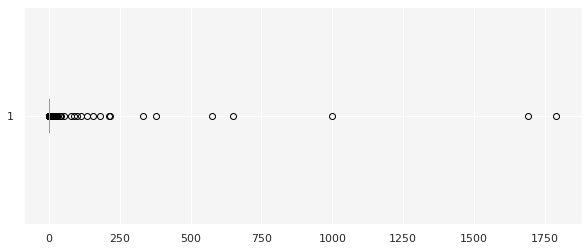

In [13]:
plt.figure(figsize=(10, 4))
plt.boxplot(allsources_art_counts, vert=False)
plt.show()


### We'd like to examine the Sources that contain the most articles. How might we set an informed threshold for article count?
### One approach is to calculate the percentiles (see below). 99% of the Sources had an Article Count of 107 or less. Let's consider the Top 1% (Sources with an Article Count > 107).


In [14]:
sources_art_count_percentiles = allsources_art_counts.quantile(np.arange(0.01, 1, 0.01))
sources_art_count_percentiles

0.01      1.00
0.02      1.00
0.03      1.00
0.04      1.00
0.05      1.00
         ...  
0.95      5.00
0.96      7.00
0.97     11.68
0.98     23.24
0.99    107.28
Name: id, Length: 99, dtype: float64


## Insight 
### The Sources in the chart below are the in the Top 1% of this dataset (based on Article Count)
- If an organization had to prioritize their Source costs (such as subscriptions/API/access fees), they might want to focus their spending on the Sources with the most ESG articles. 
- Reuters and Yahoo! News are top ranked. There may be considerable overlap in news stories as they are both general/worldwide news outlets. If analysis time was limited - it might be advantagous to choose one of these two to inspect.

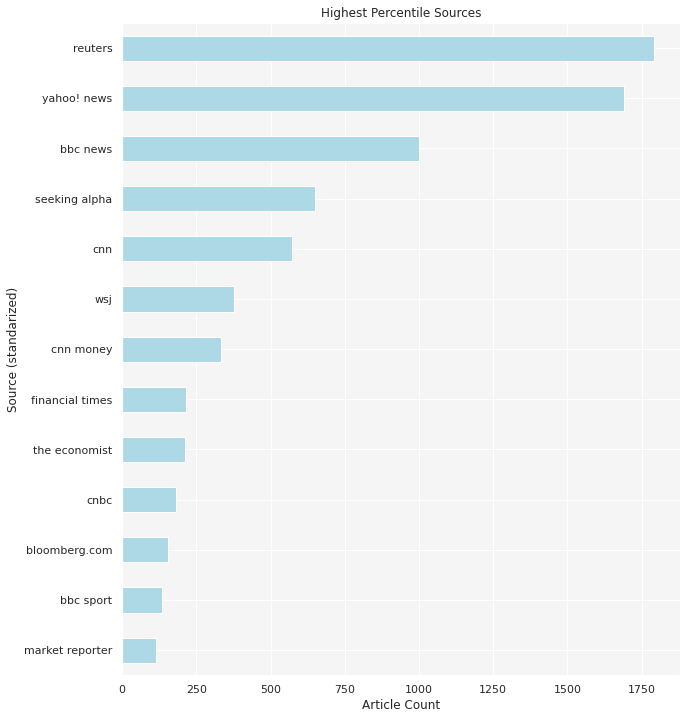

In [15]:
highest_count_sources_ordered = allsources_art_counts.loc[allsources_art_counts>107].sort_values(ascending=True)
ax = highest_count_sources_ordered.plot(kind="barh", figsize=(10,12), color="lightblue")
plt.title("Highest Percentile Sources")
plt.ylabel("Source (standarized)")
plt.xlabel("Article Count")
plt.show()